# Case Study: Project Data Driven Decision Maken to select the right crop to sow
***
### ¿Who are your stakeholders?
*  Luis Enrique Vente Yubi owner of 8 hectares at Taruga, Nasca, Ica, Peru where its trying to figure out which crop its the optimal to sow for the next 5 years. 
***
### ¿Which data did you use and where comes from? 
* I have extracted public data from FAOSTATS at the time period 2008-2020(2) related to:
    * Crops production.
    * Consumer Prices.
    * Product Prices.
    * Supply data related to the crops.
    * Macro Economic Indicators.
    * Country Investment
    * Trade Matrix of Peru.
***
### Which is your principal question?

* #### Which is the proyection to the production at the agriculture sector at the next 5 to 10 year?
***
* #### Do you have extra secundary questions?

    * ¿Como se relacionan los indicadores SDG (Sosteinable Development Goals) con la empleabilidad de la region en la agricultura?
    * ¿Cuanto cuesta el consumo de proteinas, grasas y azucares basicos para el dia a dia de las personas con los cultivos con esos compuestos al minimo precio?  
    * ¿Cuales paises tienen condiciones similares al Peru y como se desempeñaron los ultimos 3 años?
    * ¿Cuanto de la produccion del Peru se pierde por distintos motivos: putrefaccion, daños fisicos, parasitos, etc?
    * ¿Cual es el ratio sudamericano de exportaciones e importaciones en el Peru?
    * ¿Cuales son los productos que mas importa y exporta el Peru y de donde vienen o van?
    * Which import/export fertilizer dynamic have the Peru and the region? 
***

### Libraries to data cleaning, processing, analysing
***

In [90]:
import os
import squarify
import numpy as np
import pandas as pd
import seaborn as sns
from typing import Optional
import matplotlib.pyplot as plt
from IPython.display import Latex
from sklearn.neighbors import NearestNeighbors
plt.style.use('tableau-colorblind10')

In [2]:
path = "/mnt/d/data_ds/FAO_UPDATED_DATA/"
path_2 = "/mnt/d/data_ds/FAO-UPDATED-FULL-DATA-AGRO/data_3/"
files = [path+file for file in os.listdir(path) if not "ipynb" in file]

In [95]:
def nearest_neighbor_by_table(path,columns,country):
    df = pd.read_parquet(path)
    if "sdg_indicators" in path:
        df = df.loc[~df.Value.isin(["<100","N","<2.5","<0.5","<0.1"])]
        df.Value = df.Value.str.replace(",","").astype(float)
    df_pivot = df.pivot(index="Area",columns=columns,values="Value")
    df_pivot = df_pivot.fillna(0)

    try:
        nn_cos = NearestNeighbors(n_neighbors=df_pivot.shape[0],metric="cosine")
        nn_cos.fit(df_pivot)
    except Exception as e: print(e)

    diferencia,paises = nn_cos.kneighbors(df_pivot[df_pivot.index==country].values[0].reshape(1,-1))
    paises = df_pivot.iloc[paises.reshape(-1,)].index
    diferencia = diferencia.reshape(-1,)
    rango = [a for a in range(12)]#+[a for a in range(-5,0)]

    return {"y":diferencia[rango],"x":paises[rango]}

def random_plot_nn_tables(files,path,country):
    fig = plt.Figure(figsize=(26,16))
    xi = 0
    for a in range(10):
        file_name = files[a]

        if "suite" in file_name: continue
        xi += 1
        file_name = path+file_name
        ax = fig.add_subplot(3,3,xi)
        
        if "employment_indicators" in file_name:
            columns = ["Year","Sex","Indicator","Unit"]
        elif not "Months" in pd.read_parquet(file_name).columns:
            columns = ["Domain","Year","Unit","Element","Item"]
        else:
            columns = ["Year","Months","Unit","Item"]
        
        try:
            data = nearest_neighbor_by_table(path=file_name,
                                        columns=columns,
                                        country=country)
        except: 
            print(file_name)
            continue

        sub_fig = sns.barplot(data=data,x="y",y="x",ax=ax,palette="magma_r")
        q = file_name.split("/")[-1].split(".")[0]
        sub_fig.set_xlabel(f"cosine similarity between all metrics related to {q}")
        sub_fig.set_ylabel("")
        sub_fig.set(title=q)

    fig.suptitle(f"The 10 nearest countries in the period 2008-2020 to {country} at ...",fontsize=28)
    fig.subplots_adjust(wspace=0.5,top=0.92,hspace=0.3)
    return fig


In [96]:
qq = os.listdir(path_2)
country = "Peru"
fig = random_plot_nn_tables(qq,path_2,country)


/tmp/ipykernel_221/1716306298.py:3: RuntimeWarning: coroutine 'random_plot_nn_tables' was never awaited
  fig = random_plot_nn_tables(qq,path_2,country)


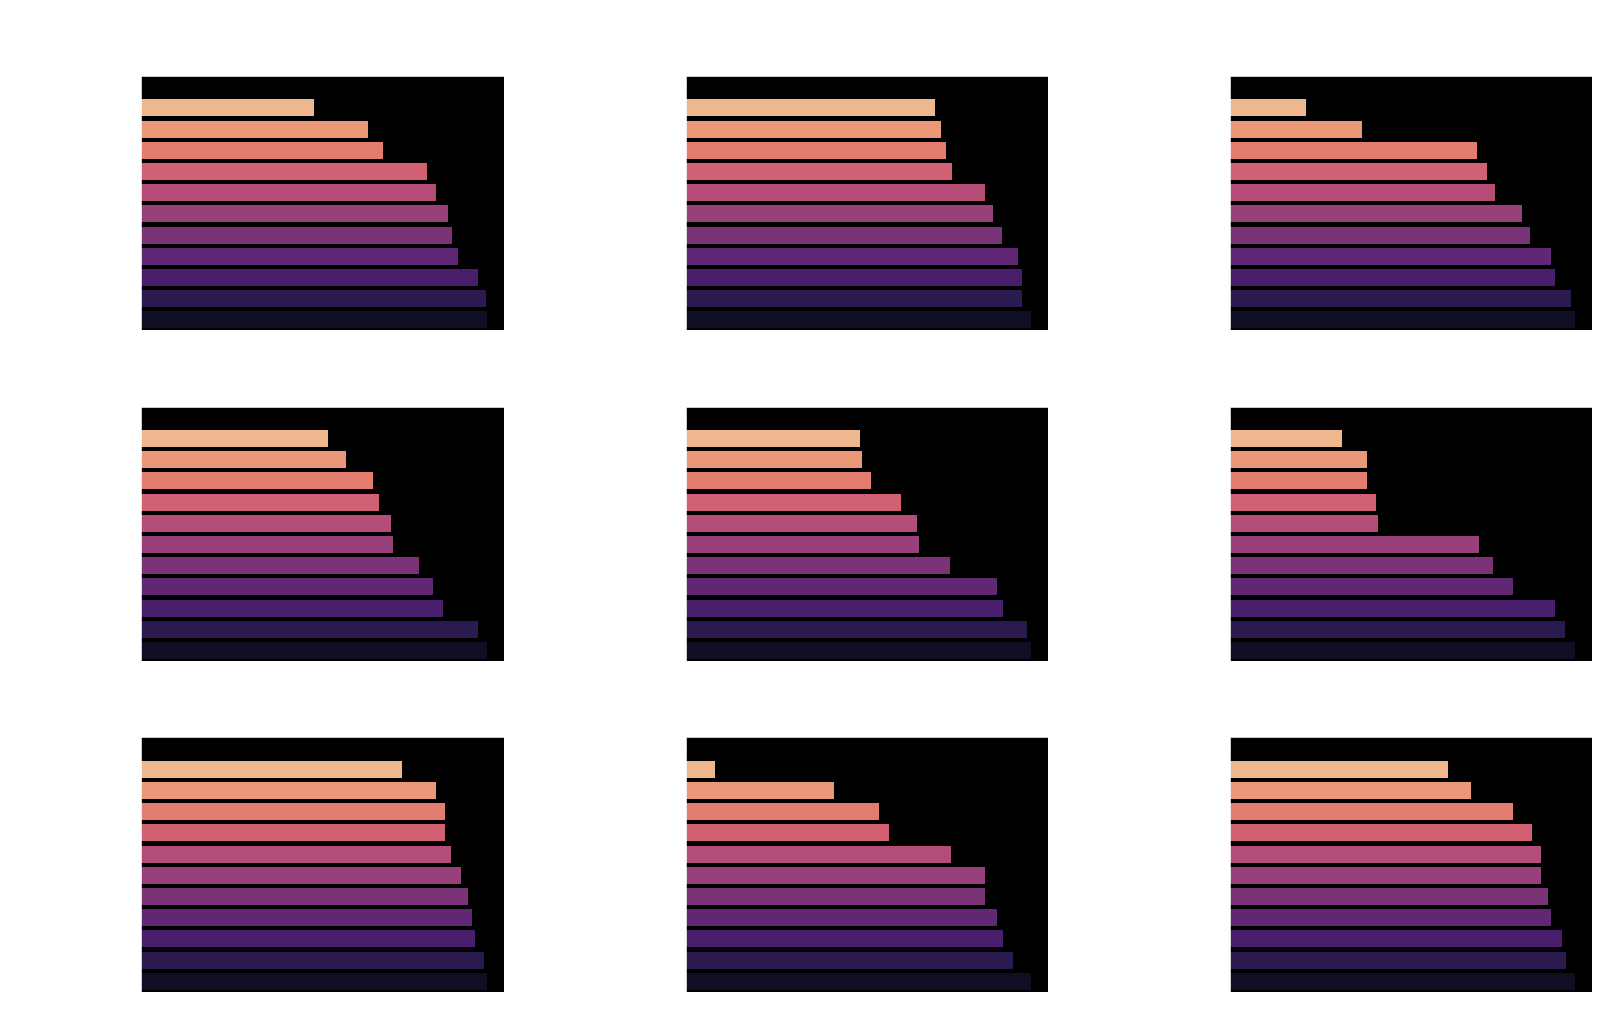

In [97]:
fig.get_figure()

In [13]:
main_df_cluster = []

for file in os.listdir(path_2):
    file = path_2+file
    if "suite_of" in file or "ipynb" in file or "credit" in file or "employment" in file: continue
    df = pd.read_parquet(file)
    cols = ["Domain","Area","Element","Item","Year","Unit","Value"]
    if "Months" in df.columns:
        df = df.loc[df.Months=="December"]
    if not "Element" in df.columns:
        df["Element"] = df.Domain.unique()[0]
    df = df[cols]
    main_df_cluster.append(df)

In [14]:
main_df = pd.concat(main_df_cluster)

In [15]:
resq = ["Supply Utilization Accounts","Crops and livestock products","Suite of Food Security Indicators"]

qq = main_df[main_df.Domain=="Producer Prices"].Item.unique()

main_df = main_df[(~main_df.Domain.isin(resq))|(main_df.Item.isin(qq))]
main_df["Unit"] = main_df.Unit.fillna("unknown")
main_df = main_df.loc[~main_df.Value.isin(["<100","N","<2.5","<0.5","<0.1"])]
main_df.Value = main_df.Value.str.replace(",","").astype(float)

In [16]:
pivot_resume_df = main_df.pivot(index="Area",columns=["Domain","Year","Unit","Element","Item"],values="Value").fillna(0)

/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [99]:
nn_cos = NearestNeighbors(n_neighbors=pivot_resume_df.shape[0],metric="cosine")
nn_cos.fit(pivot_resume_df)
country = "United States of America"
diferencia,paises = nn_cos.kneighbors(pivot_resume_df[pivot_resume_df.index==country].values[0].reshape(1,-1))
paises = pivot_resume_df.iloc[paises.reshape(-1,)].index
diferencia = diferencia.reshape(-1,)

rango = [a for a in range(15)]+[a for a in range(-15,0)]

NameError: name 'pivot_resume_df' is not defined

NameError: name 'diferencia' is not defined

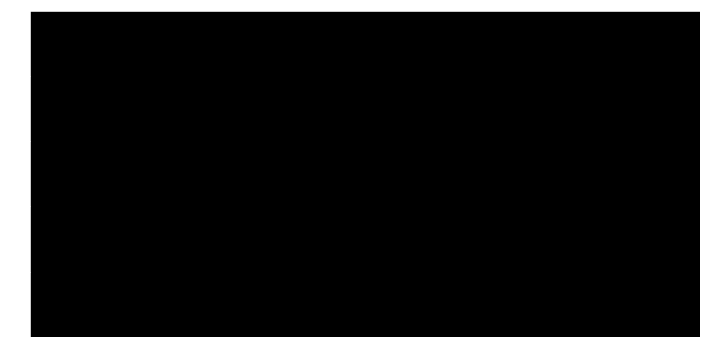

In [98]:
ax,fig = plt.subplots(figsize=(12,6))
fig = sns.barplot(data={"y":diferencia[rango],"x":paises[rango]},y="x",x="y",palette="magma_r")

fig.figure.suptitle(f"The closest countries with a similar agriculture dynamic\n to {country} based on Nearest Neighbor model",fontsize=24)
fig.figure.subplots_adjust(top=0.8)
fig.set_xlabel("cosine similarity between all metrics related to all metrics combined with all their items and elements related")
fig.set(xscale=("log"))
plt.show()

In [19]:
files = sorted(files)

col_br_ur_trade_matrix = pd.read_csv(files[0])
consumer_price = pd.read_csv(files[1])
consumer_price["Element"] = "consumer_price"
country_investment = pd.read_csv(files[2])
credit = pd.read_csv(files[7])
crops_products = pd.read_csv(files[12])
development_flow = pd.read_csv(files[3])
exchange_rates = pd.read_csv(files[4])
fertilizers_by_product = pd.read_csv(files[5])
fertilizers_indicators = pd.read_csv(files[6])
macro_indicators = pd.read_csv(files[8])
peru_chile_trade_matrix = pd.read_csv(files[9])
producer_prices = pd.read_csv(files[10])
supply = pd.read_csv(files[11],encoding="ISO-8859-1")

/tmp/ipykernel_228/2281316458.py:9: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  development_flow = pd.read_csv(files[3])


In [14]:
class DataInsightsFAO:
    def __init__(self,df:pd.DataFrame,
                 method:str,
                 element_name:str,
                 list_items:Optional[list]=[],
                 list_elements:Optional[list]=[]):
        
        self.df = df
        self.method = method
        self.element_name = element_name
        self.list_items = list_items
        self.list_elements = list_elements

    def transform_data_1(self,method="direct") -> pd.DataFrame:
        if len(self.list_items)!=0:
            items_df = self.df.Item.isin(self.list_items)
        else:
            items_df = 1
        if len(self.list_elements)!=0:
            items_df = self.df.Element.isin(self.list_elements)
        else:
            elements_df = 1
            
        main_df = self.df.loc[(items_df)&(elements_df)&(self.df.Element==self.element_name)]

        if self.method=="grouped_sum":
            main_df = main_df.groupby(["Year","Area","Item","Unit"]).Value.sum().reset_index()
        if self.method=="grouped_mean":
            main_df = main_df.groupby(["Year","Area","Item","Unit"]).Value.mean().reset_index()
        if self.method=="direct":
            main_df = main_df[["Year","Area","Item","Unit","Value"]]

        return main_df
    
    def plot_data_1(self,kind="bar",palette="bright"):
        main_df = self.transform_data_1()
        fig = sns.catplot(data=main_df,
                        x="Year",y="Value",col="Area",hue="Item",
                        kind=kind,height=6,palette=palette,col_wrap=3)
        return fig
    
        



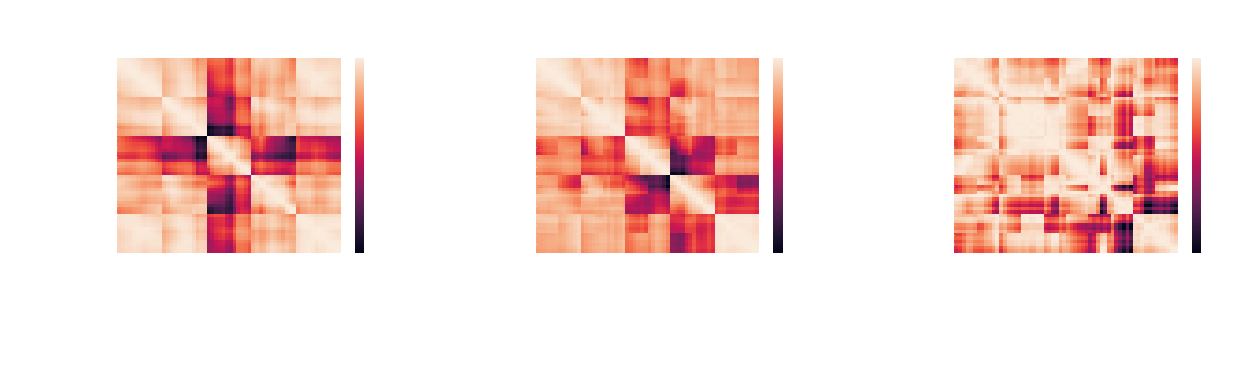

In [178]:
z_1 = consumer_price.loc[(consumer_price.Item=="Consumer Prices, Food Indices (2015 = 100)")
                        ].pivot(index=["Year","Unit"],columns=["Months","Area"],values="Value").corr()

z = consumer_price.loc[(consumer_price.Item=="Consumer Prices, Food Indices (2015 = 100)")&
                        (consumer_price.Year<2018)].pivot(index=["Year","Unit"],columns=["Months","Area"],values="Value").corr()

z_2 = consumer_price.loc[(consumer_price.Item=="Consumer Prices, Food Indices (2015 = 100)")&
                        (consumer_price.Year>=2018)].pivot(index=["Year","Unit"],columns=["Months","Area"],values="Value").corr()

fig = plt.figure(figsize=(20,4))

ax = fig.add_subplot(1,3,1)
q = sns.heatmap(z,ax=ax)
q.set_title("From 2008-2018")

ax_1 = fig.add_subplot(1,3,2)
q = sns.heatmap(z_1,ax=ax_1)
q.set_title("From 2008-2022")

ax_2 = fig.add_subplot(1,3,3)
q = sns.heatmap(z_2,ax=ax_2)
q.set_title("From 2018-2022")

fig.figure.subplots_adjust(wspace=0.5,top=0.8)
fig.figure.suptitle(f"Consumer Prices, Food Indices (2015 = 100)",fontsize=24)
plt.show()

### This show how the region has grow and fall on the last 12 years
***

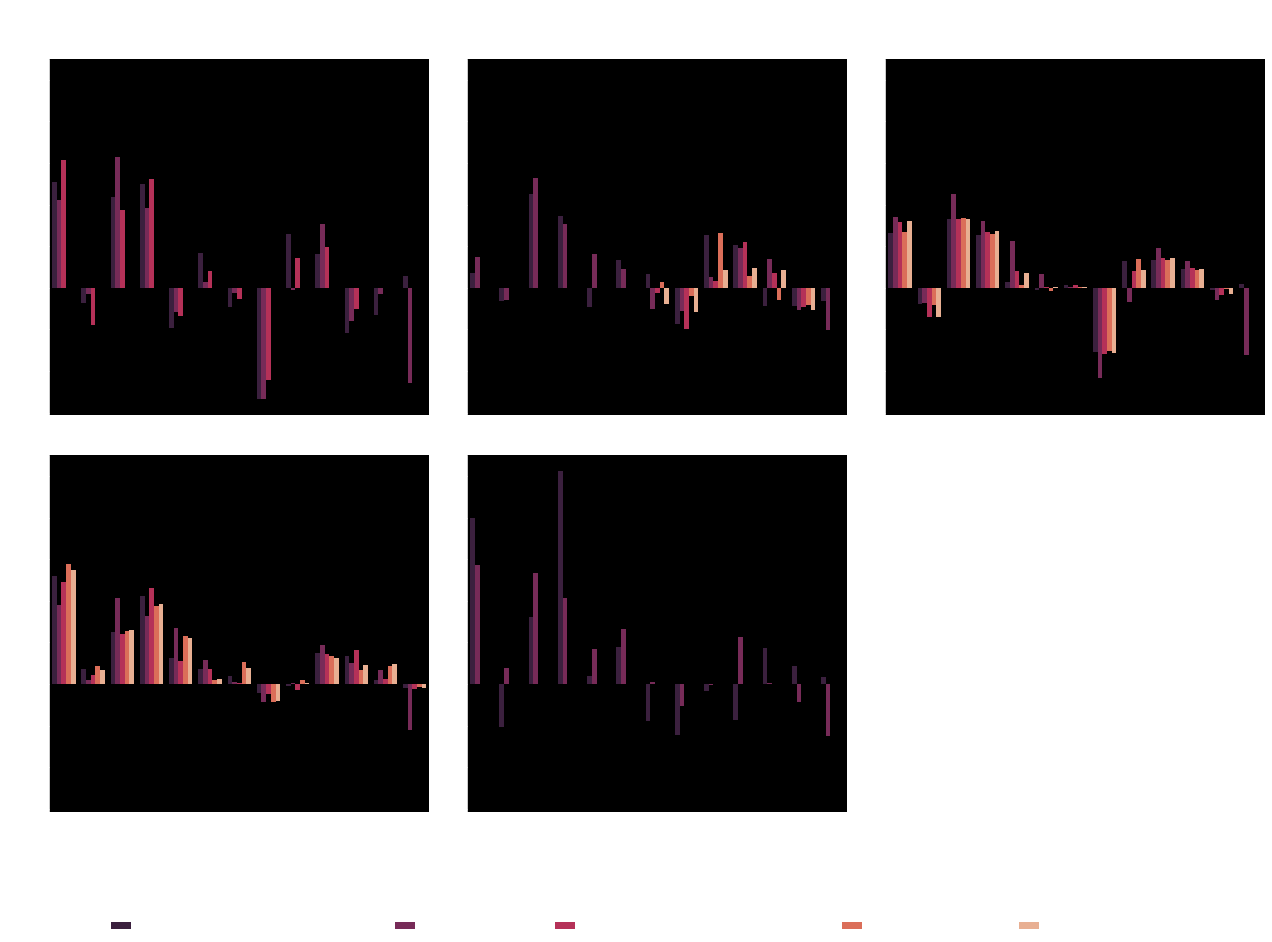

In [15]:
str_1 = ["Value Added (Agriculture)","Value Added (Agriculture, Forestry and Fishing)",
        "Gross Output (Agriculture)","Gross Output (Agriculture, Forestry and Fishing)",
        "Gross National Income"]

fig = DataInsightsFAO(macro_indicators,element_name="Annual growth US$",method="direct",list_items=str_1).plot_data_1(kind="bar",palette="rocket")

sns.move_legend(fig,"lower center",ncol=5,bbox_to_anchor=(.42, -0.1),title="Item", frameon=False)
fig.figure.suptitle("Annual growth US$",fontsize=24,x=0.42)
fig.figure.subplots_adjust(top=0.92,wspace=0.1)
plt.show()

### This plot show the porcentage of share which represent the agriculture sector to the GDP as a whole.
***

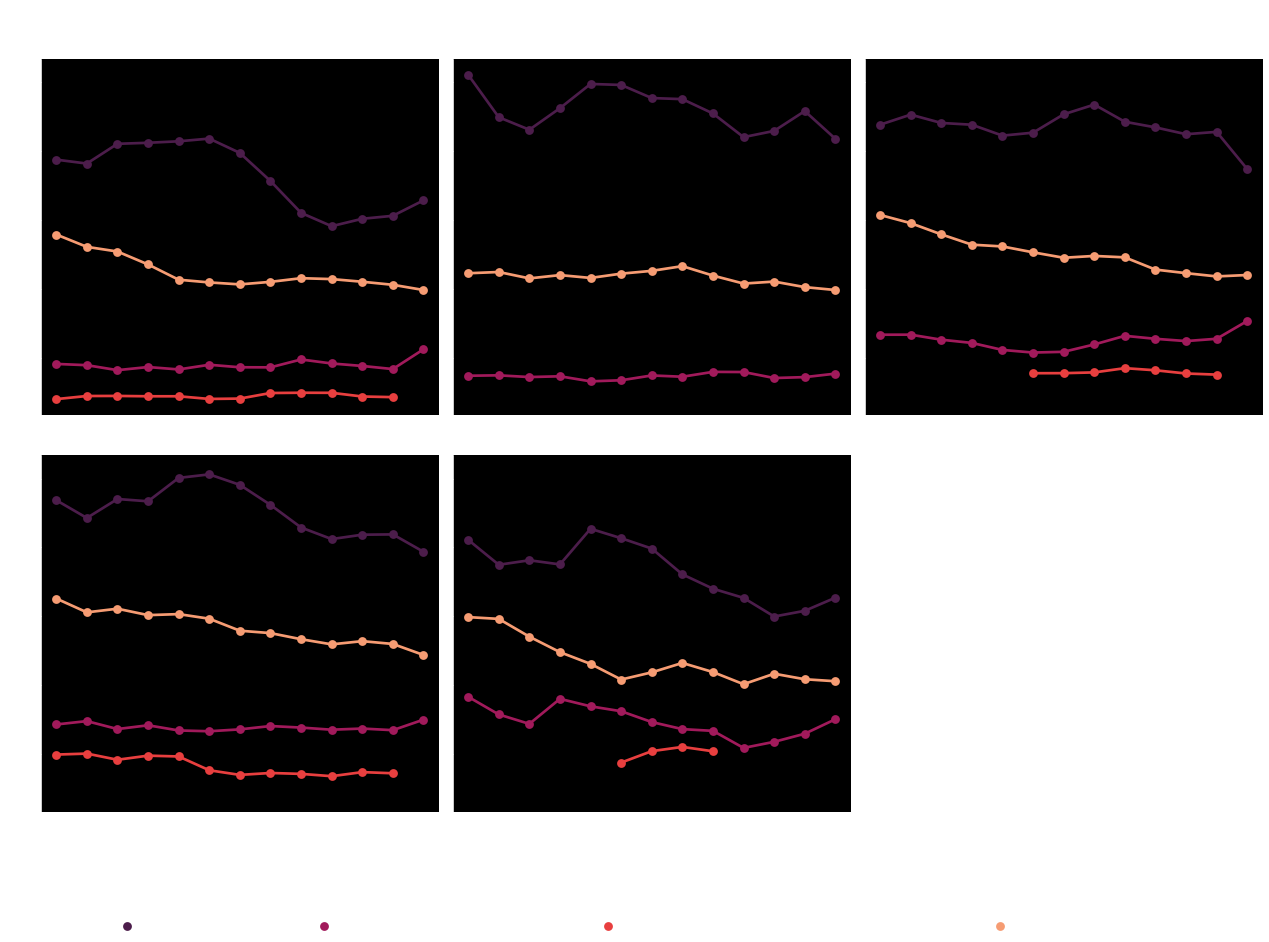

In [16]:
fig = DataInsightsFAO(macro_indicators,element_name="Share of GDP US$",method="grouped_mean").plot_data_1(kind="point",palette="rocket")

fig.figure.suptitle("Share of GDP US$",fontsize=24,x=0.4)
fig.figure.subplots_adjust(top=0.92)
sns.move_legend(fig,"lower center",ncol=4,bbox_to_anchor=(.4, -0.1),title="Item", frameon=False)
plt.show()

### Which import/export fertilizer dynamic have the Peru and the South America region?
***

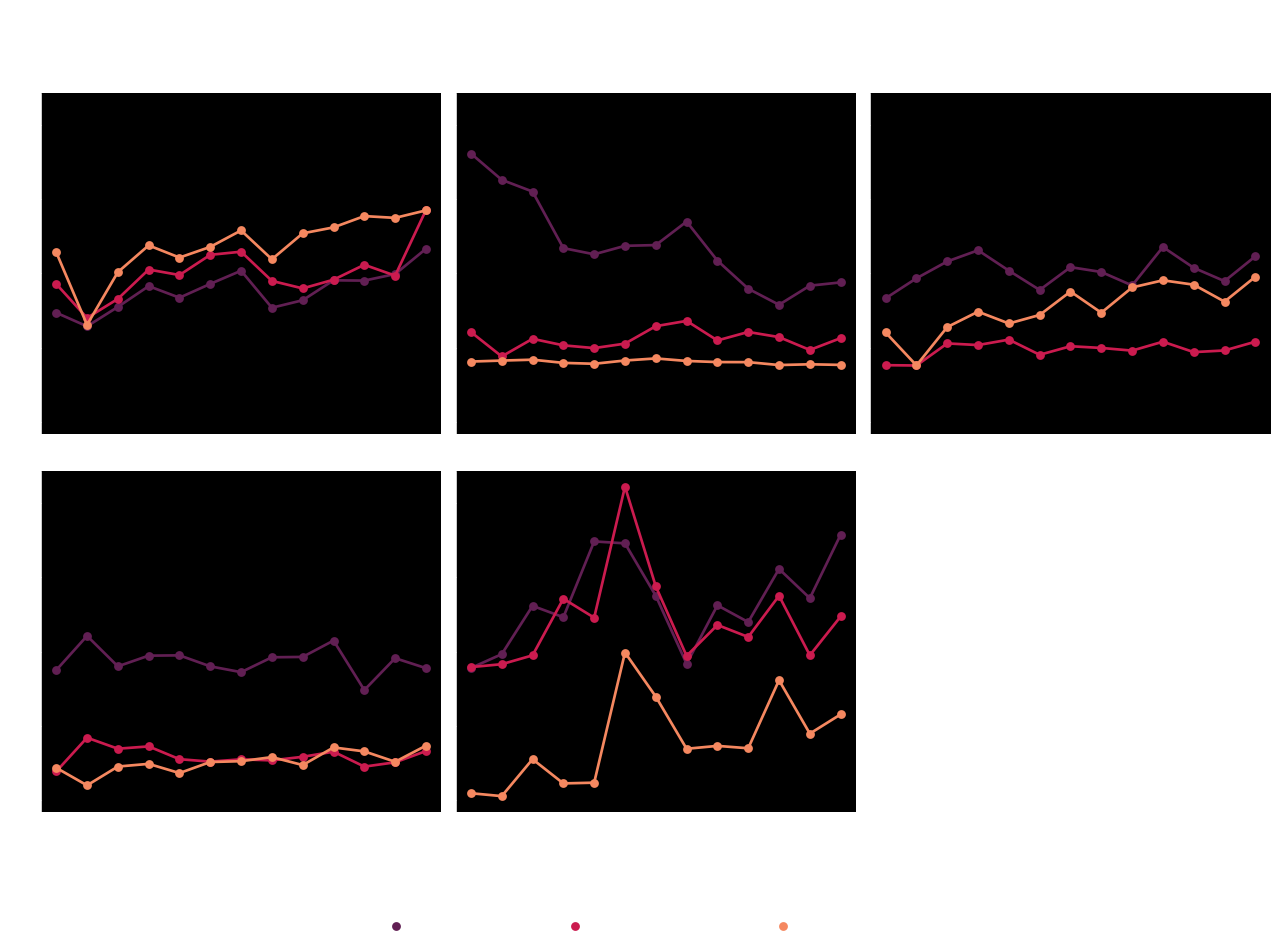

In [17]:
fig = DataInsightsFAO(fertilizers_indicators,
                      element_name="Use per value of agricultural production",
                      method="direct").plot_data_1(kind="point",palette="rocket")

fig.figure.suptitle(" Use of fertilizers per value of agricultural\n production kg/1000 Int.$",
                   fontsize=24,x=0.45)
fig.figure.subplots_adjust(top=0.88)
sns.move_legend(fig,"lower center",ncol=3,bbox_to_anchor=(.45, -0.1),title="Item", frameon=False)
plt.show()

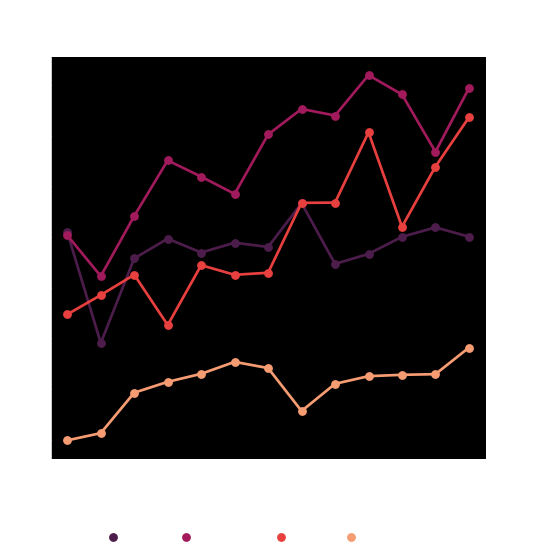

In [214]:
q_4 = fertilizers_by_product.loc[(fertilizers_by_product.Element.isin(["Import Quantity"]))&
                                (fertilizers_by_product.Area!="Brazil")].groupby(["Year","Area"]).Value.sum()

q_4 = q_4.reset_index()

fig = sns.catplot(data=q_4,x="Year",y="Value",hue="Area",kind="point",height=7,palette="rocket")#["Blue","Yellow","Red","SkyBlue"])

fig.figure.suptitle("Import Quantity of Fertilizers per Country",fontsize=24)
fig.figure.subplots_adjust(top=0.88)
sns.move_legend(fig,"lower center",ncol=4,bbox_to_anchor=(.46, -0.1),title="Item", frameon=False)
plt.show()

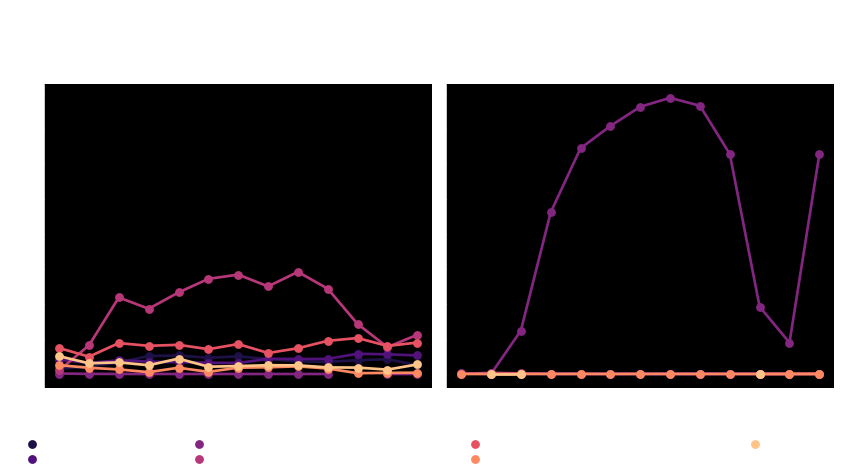

In [215]:
q_3 = fertilizers_by_product.loc[(fertilizers_by_product.Element.isin(["Export Quantity"]))&
                                (fertilizers_by_product.Area.isin(["Chile","Peru"]))]
q_4 = q_3.groupby(["Year","Area","Item"]).Value.sum()
q_4 = q_4.reset_index()
q_5 = q_3.groupby(["Area","Item"]).Value.sum().reset_index()
q_5 = q_5.loc[q_5.Value>0.5e+6].Item.unique()
q_4 = q_4.loc[q_4.Item.isin(q_5)]
fig = sns.catplot(data=q_4,x="Year",y="Value",hue="Item",
            color="Value",col="Area",kind="point",palette="magma",
            height=6,col_wrap=2)

fig.figure.suptitle("Fertilizers by product on South America which total export quantity\n at the last 12 year that its higher than 500000 tonnes",x=0.38,fontsize=24)
fig.figure.subplots_adjust(top=0.8)
sns.move_legend(fig,"lower center",ncol=4,bbox_to_anchor=(.4, -0.1),title="Item", frameon=False)
plt.show()

In [20]:
trade_matrix = pd.concat([col_br_ur_trade_matrix,peru_chile_trade_matrix])

trade_matrix_2 = trade_matrix.pivot(index=["Reporter Countries","Partner Countries","Year","Item"],
                   columns=["Element"],
                   values="Value")

trade_matrix_2 = trade_matrix_2.reset_index()
trade_matrix_2 = trade_matrix_2.fillna(0)

### Import and Export Quantity visualized, it show how the last 5 years Peru have start to grow our exportation rate compered to past years.
***

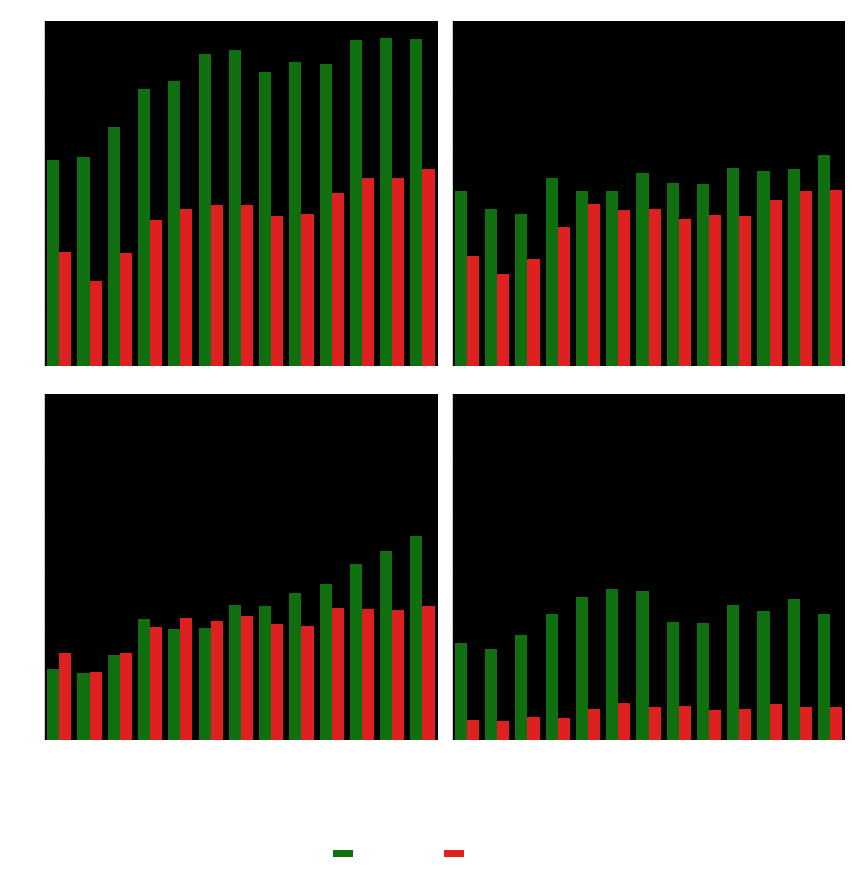

In [21]:
q = trade_matrix.groupby(["Reporter Countries","Element","Year"]).Value.sum()
q = q.reset_index()
q = q.loc[q["Reporter Countries"]!="Brazil"]

fig = sns.catplot(data=q,x="Year",y="Value",hue="Element",
            col="Reporter Countries",kind="bar",
            height=6,palette=["Green","Red"],col_wrap=2)
fig.figure.subplots_adjust(top=0.88)
sns.move_legend(fig,"lower center",ncol=4,bbox_to_anchor=(.46, -0.1),title="Item", frameon=False)
plt.show()

### Amount of loss production on the region which clearly show the high loss rate compered to the open stock of production at Peru.
***

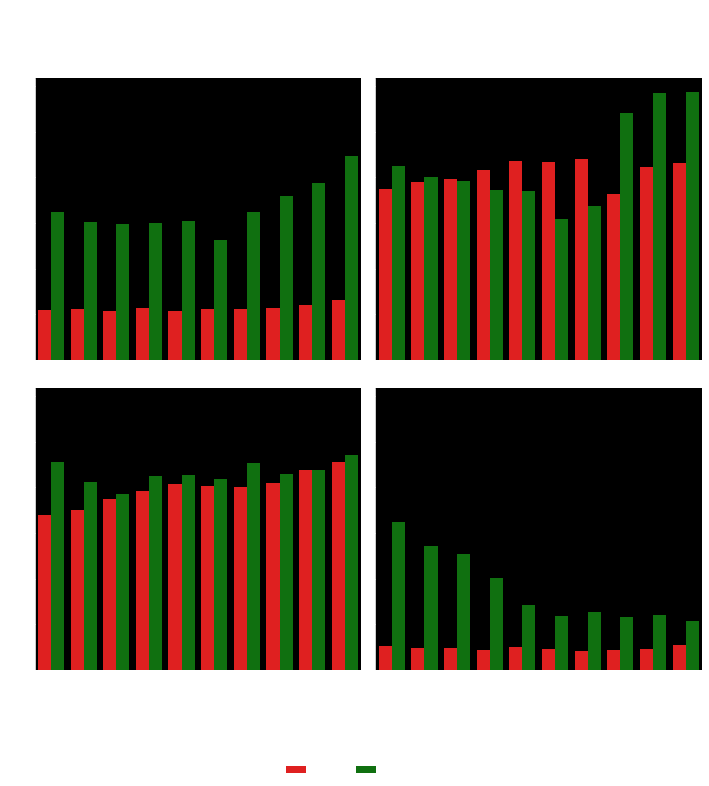

In [22]:
list_of_elements = ["Loss","Opening stocks"]

q = supply[(supply.Area!="Brazil")&
           (supply.Element.isin(list_of_elements))
          ].groupby(["Area","Year","Element"]).sum().reset_index()

fig = sns.catplot(data=q,x="Year",y="Value",hue="Element",col="Area",kind="bar",palette=["Red","Green"],col_wrap=2)
fig.figure.suptitle("Loss and Opening Stocks in South America",x=0.45,fontsize=16)
fig.figure.subplots_adjust(top=0.88)
sns.move_legend(fig,"lower center",ncol=4,bbox_to_anchor=(.46, -0.1),title="Item", frameon=False)
plt.show()